# Task 2: RNN application -- Tweet Sentiment Analysis

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import json
import time
import matplotlib.pyplot as plt
import pickle

# Plot configurations
% matplotlib inline
# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

### Load data

In [2]:
with open("./tweets_data/vocabulary.pkl", "rb") as f:
    vocabulary = pickle.load(f)

# load our data and separate it into tweets and labels
train_data = json.load(open('tweets_data/trainTweets_preprocessed.json', 'r'))
train_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),train_data))
train_tweets = np.array([t[0] for t in train_data])
train_labels = np.array([int(t[1]) for t in train_data])

test_data = json.load(open('tweets_data/testTweets_preprocessed.json', 'r'))
test_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),test_data))
test_tweets = np.array([t[0] for t in test_data])
test_labels = np.array([int(t[1]) for t in test_data])

print("size of original train set: {}".format(len(train_tweets)))
print("size of original test set: {}".format(len(test_tweets)))

# only select first 1000 test sample for test
test_tweets = test_tweets[:1000]
test_labels = test_labels[:1000]

print("*"*100)
print("size of train set: {}, #positive: {}, #negative: {}".format(len(train_tweets), np.sum(train_labels), len(train_tweets)-np.sum(train_labels)))
print("size of test set: {}, #positive: {}, #negative: {}".format(len(test_tweets), np.sum(test_labels), len(test_tweets)-np.sum(test_labels)))

# show text of the idx-th train tweet
# The 'padtoken' is used to ensure each tweet has the same length
idx = 100
train_text = [vocabulary[x] for x in train_tweets[idx]]
print(train_text)
sentiment_label = ["negative", "positive"]
print("sentiment: {}".format(sentiment_label[train_labels[idx]]))

size of original train set: 60000
size of original test set: 20000
****************************************************************************************************
size of train set: 60000, #positive: 30055, #negative: 29945
size of test set: 1000, #positive: 510, #negative: 490
['it', 'will', 'help', 'relieve', 'your', 'stress', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken']
sentiment: positive


In [3]:
print(train_tweets)
print(train_tweets.shape)
print(test_tweets)
print(test_labels.shape)

[[ 345   55 3679 ...,    1    1    1]
 [  20 1563    1 ...,    1    1    1]
 [ 256   75 1172 ...,    1    1    1]
 ..., 
 [   2  108   90 ...,    1    1    1]
 [ 188    2 1842 ...,    1    1    1]
 [1148   27  487 ...,    1    1    1]]
(60000, 20)
[[   2    1    1 ...,    1    1    1]
 [  23    2   62 ...,    1    1    1]
 [   2   14  532 ...,    1    1    1]
 ..., 
 [   2   40  121 ...,    1    1    1]
 [1012   10   30 ...,    1    1    1]
 [   2  441    1 ...,    1    1    1]]
(1000,)


## Part 1: LSTM Encoder

### train a single-layer lstm network

First of all, we'll build a single-layer LSTM network for the analysis. The network structure is the following:

![](./img/singleLSTM.png)

<span style="color:red">__TODO:__</span> Below, we've defined the network for you. Please read the code carefully to make sure you understand it. Then, please write a training function to train this network. The settings are:

1. Train the network for 1000 iterations. In each iteration, use batch_size samples to train the network.
2. For every 50 iterations, apply the network on the test set, and print out the test accuracy and mean loss.

With these settings, what accuracy could you get? You can try to change some stuff in the network to see if you could get a better accuracy (this is optional).

In [3]:
# define a linear layer, y = x*w + b
def linear(input_, output_size, name, init_bias=0.0):
    shape = input_.get_shape().as_list()
    with tf.variable_scope(name):
        init = tf.truncated_normal([shape[-1], output_size], mean=0.0, stddev=1.0 / shape[-1]**0.5)
        W = tf.get_variable("weight", initializer=init)
    if init_bias is None:
        return tf.matmul(input_, W)
    with tf.variable_scope(name):
        b = tf.get_variable("bias", [output_size], initializer=tf.constant_initializer(init_bias))
    return tf.matmul(input_, W) + b   

In [4]:
# set variables
tweet_size = 20
hidden_size = 100
vocab_size = 7597
batch_size = 64

# this just makes sure that all our following operations will be placed in the right graph.
tf.reset_default_graph()

# make placeholders for data we'll feed in
tweets = tf.placeholder(tf.int32, [None, tweet_size])
labels = tf.placeholder(tf.float32, [None])

tweets_onehot = tf.one_hot(tweets, depth=vocab_size, axis=-1)

# define the lstm cell
lstm_cell = tf.contrib.rnn.LSTMCell(hidden_size)

# define the op that runs the LSTM, across time, on the data
init_state = lstm_cell.zero_state(batch_size, tf.float32)
#init_state = lstm_cell.zero_state(tf.shape(labels)[0], tf.float32)
outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, tweets_onehot, initial_state=init_state, dtype=tf.float32)
print('outputs is ',outputs)
print('final_state is ',final_state)
# define that our final sentiment logit is a linear function of the final state of the LSTM
sentiment = linear(final_state[-1], 1, name="output")

# define cross entropy/sigmoid loss function
sentiment = tf.squeeze(sentiment, [1])
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=sentiment, labels=labels)
loss = tf.reduce_mean(loss)

# compute accuracy
prob = tf.nn.sigmoid(sentiment)
prediction = tf.to_float(tf.greater_equal(prob, 0.5))
acc = tf.to_float(tf.equal(prediction, labels))
acc = tf.reduce_mean(acc)

# define optimizer
trainer = tf.train.AdamOptimizer()
gradients = trainer.compute_gradients(loss)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)

outputs is  Tensor("rnn/transpose:0", shape=(64, 20, 100), dtype=float32)
final_state is  LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(64, 100) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(64, 100) dtype=float32>)


train step 50, i.e. test step 1: test_loss = 0.6550866365432739, test_acc = 0.59375 and mean training loss = 0.6756088277872871
train step 100, i.e. test step 2: test_loss = 0.5622677206993103, test_acc = 0.765625 and mean training loss = 0.627291192512701
train step 150, i.e. test step 3: test_loss = 0.6083633899688721, test_acc = 0.703125 and mean training loss = 0.5988449016154207
train step 200, i.e. test step 4: test_loss = 0.5541245341300964, test_acc = 0.75 and mean training loss = 0.5831213187222457
train step 250, i.e. test step 5: test_loss = 0.5983010530471802, test_acc = 0.6875 and mean training loss = 0.5727048971026067
train step 300, i.e. test step 6: test_loss = 0.5261391997337341, test_acc = 0.71875 and mean training loss = 0.5666067921046006
train step 350, i.e. test step 7: test_loss = 0.6282404661178589, test_acc = 0.734375 and mean training loss = 0.5589612020216777
train step 400, i.e. test step 8: test_loss = 0.5996931195259094, test_acc = 0.6875 and mean trainin

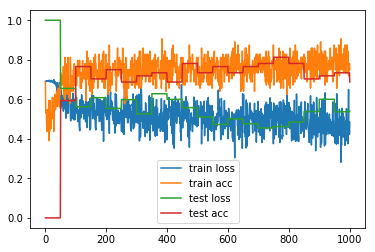

In [5]:
# Training function
num_steps = 1001
train_loss_hist=[]
train_acc_hist=[]
test_loss_hist=[]
test_acc_hist=[]
test_loss=1.0
test_acc=0.0
test_step_no=0
test_step_no_print=0
train_step_use=0
mean_train_loss=0
total_train_loss=0
mean_test_accuracy=0
total_test_accuracy=0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    test_step_no=0
    test_step_no_print=0
    train_step_use=0
    for step in range(num_steps):
        # TODO: get data for a batch
        if(step>935):
            train_step_use=step-935
        else:
            train_step_use=step
        batch_tweets = train_tweets[train_step_use * batch_size: (1 + train_step_use) * batch_size]
        batch_labels = train_labels[train_step_use * batch_size: (1 + train_step_use) * batch_size]
        #training_batch_x = X_train[itr * batch_size: (1 + itr) * batch_size]
        #training_batch_y = y_train[itr * batch_size: (1 + itr) * batch_size]
        
        # TODO: run the 'optimizer', 'loss', and 'acc' operations in the graph using the batch data
        sess.run(optimizer, feed_dict={tweets: batch_tweets, labels: batch_labels})
        train_loss=sess.run(loss, feed_dict={tweets: batch_tweets, labels: batch_labels})
        train_acc=sess.run(acc, feed_dict={tweets: batch_tweets, labels: batch_labels})
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc)
        total_train_loss=total_train_loss+train_loss
        mean_train_loss=total_train_loss/(step+1)
        #print('step {}: train_loss = {} and train_acc = {}'.format(step+1, train_loss,train_acc))
        #_, train_loss, train_acc = pass
                
        if ((step % 50 == 0) and (step>10)):
            # TODO: get test accuracy and loss, and print them out.
            #test_step=int(step/50)
            test_batch_tweets = test_tweets[test_step_no * batch_size: (1 + test_step_no) * batch_size]
            test_batch_labels = test_labels[test_step_no * batch_size: (1 + test_step_no) * batch_size] 
            #test_batch_tweets=test_tweets
            #test_batch_labels=test_labels
            test_loss=sess.run(loss, feed_dict={tweets: test_batch_tweets, labels: test_batch_labels})
            test_acc=sess.run(acc, feed_dict={tweets: test_batch_tweets, labels: test_batch_labels})
            test_loss_hist.append(test_loss)
            test_acc_hist.append(test_acc)
            total_test_accuracy=total_test_accuracy+test_acc
            print('train step {}, i.e. test step {}: test_loss = {}, test_acc = {} and mean training loss = {}'.format(step,test_step_no_print+1, test_loss,test_acc,mean_train_loss))
            test_step_no=test_step_no+1
            test_step_no_print=test_step_no_print+1
            if(test_step_no==15):
                test_step_no=1
        else:
            test_loss_hist.append(test_loss)
            test_acc_hist.append(test_acc)
    mean_test_accuracy=total_test_accuracy/20
    print('Final Step no {}: Final mean train_loss = {}, Final mean test accuracy = {} and Final step train_loss = {}'.format(step+1, mean_train_loss,mean_test_accuracy,train_loss))
    plt.plot(train_loss_hist, label="train loss")
    plt.plot(train_acc_hist, label="train acc")
    plt.plot(test_loss_hist, label="test loss")
    plt.plot(test_acc_hist, label="test acc")
    plt.legend()
    plt.show()

In [34]:
#Please note the above printed values for Final mean train_loss = 0.516863959622788, Final mean test accuracy = 0.734375
#are as per the guidelines given by TA Tingyu Mao in Piazza Post no https://piazza.com/class/j724is6jana3l7?cid=295
#and TA Jingyu Qian in Piazza Post no https://piazza.com/class/j724is6jana3l7?cid=291

In [21]:
#SOME EXPERIMENTS BELOW
train_loss_hist_STORE1=train_loss_hist
train_acc_hist_STORE1=train_acc_hist
test_loss_hist_STORE1=test_loss_hist
test_acc_hist_STORE1=test_acc_hist

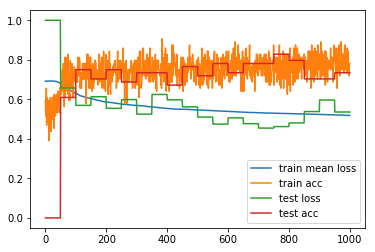

In [25]:
train_mean_loss_hist=[]
train_cumu_loss=0
train_running_avg_loss=0
index=0
for idno in range(1000):
    train_cumu_loss=train_cumu_loss+float(train_loss_hist_STORE1[idno])
    train_running_avg_loss=train_cumu_loss/(idno+1)
    train_mean_loss_hist.append(train_running_avg_loss)
    index=index+1
    
plt.plot(train_mean_loss_hist, label="train mean loss")
plt.plot(train_acc_hist_STORE1, label="train acc")
plt.plot(test_loss_hist_STORE1, label="test loss")
plt.plot(test_acc_hist_STORE1, label="test acc")
plt.legend()
plt.show()

### train a two-layer lstm network

Next, we look at a slightly more difficult network structure: a double-layer LSTM. The output of the first LSTM cell is propagated to the second LSTM cell. We only need to make small modifications to the previous network to construct this one.

![](./img/doubleLSTM.png)

<span style="color:red">__TODO:__</span> Define this double-layer LSTM in the below notebook cell. You can copy the single-layer network code and make changes to it. After that, train the network using the function you just wrote.

Hint: Use **tf.contrib.rnn.MultiRNNCell**. You'll find there are only 2-3 lines of code that need to be changed.

In [17]:
# YOUR DOUBLE-LAYER LSTM Here
# define a linear layer, y = x*w + b
def linear(input_, output_size, name, init_bias=0.0):
    shape = input_.get_shape().as_list()
    with tf.variable_scope(name):
        init = tf.truncated_normal([shape[-1], output_size], mean=0.0, stddev=1.0 / shape[-1]**0.5)
        W = tf.get_variable("weight", initializer=init)
    if init_bias is None:
        return tf.matmul(input_, W)
    with tf.variable_scope(name):
        b = tf.get_variable("bias", [output_size], initializer=tf.constant_initializer(init_bias))
    return tf.matmul(input_, W) + b  

In [18]:
# set variables
tweet_size = 20
hidden_size = 100
vocab_size = 7597
batch_size = 64

# this just makes sure that all our following operations will be placed in the right graph.
tf.reset_default_graph()

# make placeholders for data we'll feed in
tweets = tf.placeholder(tf.int32, [None, tweet_size])
labels = tf.placeholder(tf.float32, [None])

tweets_onehot = tf.one_hot(tweets, depth=vocab_size, axis=-1)

# define the lstm cell
no_layers=2
#cell = tf.nn.rnn_cell.LSTMCell(state_size, state_is_tuple=True)
#cell = tf.nn.rnn_cell.MultiRNNCell([cell] * num_layers, state_is_tuple=True)
lstm_cell_1 = tf.contrib.rnn.LSTMCell(hidden_size)
lstm_cell_2 = tf.contrib.rnn.LSTMCell(hidden_size)
lstm_cell_multi = tf.contrib.rnn.MultiRNNCell(cells=[lstm_cell_1, lstm_cell_2])

#lstm_cell = tf.contrib.rnn.LSTMCell(hidden_size)
#lstm_cell_multi = tf.contrib.rnn.MultiRNNCell([lstm_cell]*no_layers) #CHANGED HERE

# define the op that runs the LSTM, across time, on the data
init_state = lstm_cell_multi.zero_state(batch_size, tf.float32)
outputs, final_state = tf.nn.dynamic_rnn(lstm_cell_multi, tweets_onehot, initial_state=init_state, dtype=tf.float32)
print('outputs is ',outputs)
print('final_state is ',final_state)
#init_state = lstm_cell_multi.zero_state(tf.shape(labels)[0], tf.float32)
#outputs, final_state = tf.nn.dynamic_rnn(lstm_cell_multi, tweets_onehot, initial_state=init_state, dtype=tf.float32) #CHANGED HERE

# define that our final sentiment logit is a linear function of the final state of the LSTM
#final_state_used=final_state[1]
sentiment = linear(final_state[-1][-1], 1, name="output") #CHANGED HERE

# define cross entropy/sigmoid loss function
sentiment = tf.squeeze(sentiment, [1])
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=sentiment, labels=labels)
loss = tf.reduce_mean(loss)

# compute accuracy
prob = tf.nn.sigmoid(sentiment)
prediction = tf.to_float(tf.greater_equal(prob, 0.5))
acc = tf.to_float(tf.equal(prediction, labels))
acc = tf.reduce_mean(acc)

# define optimizer
trainer = tf.train.AdamOptimizer()
gradients = trainer.compute_gradients(loss)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)

outputs is  Tensor("rnn/transpose:0", shape=(64, 20, 100), dtype=float32)
final_state is  (LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(64, 100) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(64, 100) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_4:0' shape=(64, 100) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_5:0' shape=(64, 100) dtype=float32>))


train step 50, i.e. test step 1: test_loss = 0.6401662826538086, test_acc = 0.671875 and mean training loss = 0.6489521884450725
train step 100, i.e. test step 2: test_loss = 0.5384102463722229, test_acc = 0.796875 and mean training loss = 0.6102414874747248
train step 150, i.e. test step 3: test_loss = 0.5887268781661987, test_acc = 0.6875 and mean training loss = 0.5842469970122078
train step 200, i.e. test step 4: test_loss = 0.5508347749710083, test_acc = 0.75 and mean training loss = 0.5701038927877721
train step 250, i.e. test step 5: test_loss = 0.5898932218551636, test_acc = 0.734375 and mean training loss = 0.5609893739460949
train step 300, i.e. test step 6: test_loss = 0.5313346982002258, test_acc = 0.75 and mean training loss = 0.5562768887443796
train step 350, i.e. test step 7: test_loss = 0.6237496137619019, test_acc = 0.734375 and mean training loss = 0.5492525022593658
train step 400, i.e. test step 8: test_loss = 0.590978741645813, test_acc = 0.671875 and mean trainin

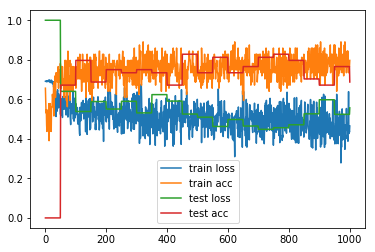

In [19]:
# YOUR TRAINING HERE
# Training function
num_steps = 1001
train_loss_hist=[]
train_acc_hist=[]
test_loss_hist=[]
test_acc_hist=[]
test_loss=1.0
test_acc=0.0
test_step_no=0
test_step_no_print=0
train_step_use=0
mean_train_loss=0
total_train_loss=0
mean_test_accuracy=0
total_test_accuracy=0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    test_step_no=0
    test_step_no_print=0
    train_step_use=0
    for step in range(num_steps):
        # TODO: get data for a batch
        if(step>935):
            train_step_use=step-935
        else:
            train_step_use=step
        batch_tweets = train_tweets[train_step_use * batch_size: (1 + train_step_use) * batch_size]
        batch_labels = train_labels[train_step_use * batch_size: (1 + train_step_use) * batch_size]
        #training_batch_x = X_train[itr * batch_size: (1 + itr) * batch_size]
        #training_batch_y = y_train[itr * batch_size: (1 + itr) * batch_size]
        
        # TODO: run the 'optimizer', 'loss', and 'acc' operations in the graph using the batch data
        sess.run(optimizer, feed_dict={tweets: batch_tweets, labels: batch_labels})
        train_loss=sess.run(loss, feed_dict={tweets: batch_tweets, labels: batch_labels})
        train_acc=sess.run(acc, feed_dict={tweets: batch_tweets, labels: batch_labels})
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc)
        total_train_loss=total_train_loss+train_loss
        mean_train_loss=total_train_loss/(step+1)
        #print('step {}: train_loss = {} and train_acc = {}'.format(step+1, train_loss,train_acc))
        #_, train_loss, train_acc = pass
                
        if ((step % 50 == 0) and (step>10)):
            # TODO: get test accuracy and loss, and print them out.
            #test_step=int(step/50)
            test_batch_tweets = test_tweets[test_step_no * batch_size: (1 + test_step_no) * batch_size]
            test_batch_labels = test_labels[test_step_no * batch_size: (1 + test_step_no) * batch_size] 
            #test_batch_tweets=test_tweets
            #test_batch_labels=test_labels
            test_loss=sess.run(loss, feed_dict={tweets: test_batch_tweets, labels: test_batch_labels})
            test_acc=sess.run(acc, feed_dict={tweets: test_batch_tweets, labels: test_batch_labels})
            test_loss_hist.append(test_loss)
            test_acc_hist.append(test_acc)
            total_test_accuracy=total_test_accuracy+test_acc
            print('train step {}, i.e. test step {}: test_loss = {}, test_acc = {} and mean training loss = {}'.format(step,test_step_no_print+1, test_loss,test_acc,mean_train_loss))
            test_step_no=test_step_no+1
            test_step_no_print=test_step_no_print+1
            if(test_step_no==15):
                test_step_no=1
        else:
            test_loss_hist.append(test_loss)
            test_acc_hist.append(test_acc)
    mean_test_accuracy=total_test_accuracy/20
    print('Final Step no {}: Final mean train_loss = {}, Final mean test accuracy = {} and Final step train_loss = {}'.format(step+1, mean_train_loss,mean_test_accuracy,train_loss))
    plt.plot(train_loss_hist, label="train loss")
    plt.plot(train_acc_hist, label="train acc")
    plt.plot(test_loss_hist, label="test loss")
    plt.plot(test_acc_hist, label="test acc")
    plt.legend()
    plt.show()

## Part 2: Embedding Lookup layer

![](./img/embedding.png)

###  Define an embedding layer

It's not hard to imagine in the previous practices, the input we fed in are very sparse because each word was represented as a one-hot vector. This makes it difficult for the network to understand what story the input data is telling. 

Word embedding: instead of using a one-hot vector to represent each word, we can add an word embedding matrix in which each word is represented as a low-dimensional vector. Note that this representation is not sparse any more, because we're working in a continuous vector space now. Words that share similar/related semantic meaning should be 'close to each other' in this vector space (we could define a distance measure to estimate the closeness). 

[https://www.tensorflow.org/tutorials/word2vec](https://www.tensorflow.org/tutorials/word2vec)

<span style="color:red">__TODO:__</span> Take a look at the website above, and write a function to do the embedding. The website itself is a very good tutorial.

Hint: Use **tf.nn.embedding_lookup**

In [20]:
def embedding(input_, vocab_size, output_size, name):
    """
    1. Define an embedding matrix
    2. return both the lookup results and the embedding matrix.
    """
    embedding_matrix = tf.Variable(tf.random_uniform([vocab_size, output_size], -1.0, 1.0),name = name)
    lookup_result = tf.nn.embedding_lookup(embedding_matrix, input_)
    return embedding_matrix,lookup_result
# YOUR CODE HERE
def linear(input_, output_size, name, init_bias=0.0):
    shape = input_.get_shape().as_list()
    with tf.variable_scope(name):
        init = tf.truncated_normal([shape[-1], output_size], mean=0.0, stddev=1.0 / shape[-1]**0.5)
        W = tf.get_variable("weight", initializer=init)
    if init_bias is None:
        return tf.matmul(input_, W)
    with tf.variable_scope(name):
        b = tf.get_variable("bias", [output_size], initializer=tf.constant_initializer(init_bias))
    return tf.matmul(input_, W) + b 

### Train a single lstm network with embedding layer

<span style="color:red">__TODO:__</span> Build a single-layer LSTM network according to the network structure. Then, train the network with the training function you wrote.

In [22]:
# set variables
tweet_size = 20
hidden_size = 100
vocab_size = 7597
batch_size = 64
output_size = 200

# this just makes sure that all our following operations will be placed in the right graph.
tf.reset_default_graph()

# make placeholders for data we'll feed in
tweets = tf.placeholder(tf.int32, [None, tweet_size])
labels = tf.placeholder(tf.float32, [None])

#tweets_onehot = tf.one_hot(tweets, depth=vocab_size, axis=-1)
embedding_matrix, lookup_result = embedding(tweets,vocab_size,output_size,'embedding_matrix')

# define the lstm cell
lstm_cell = tf.contrib.rnn.LSTMCell(hidden_size)

# define the op that runs the LSTM, across time, on the data
init_state = lstm_cell.zero_state(batch_size, tf.float32)
#init_state = lstm_cell.zero_state(tf.shape(labels)[0], tf.float32)
outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, lookup_result, initial_state=init_state, dtype=tf.float32)
print('outputs is ',outputs)
print('final_state is ',final_state)
# define that our final sentiment logit is a linear function of the final state of the LSTM
sentiment = linear(final_state[-1], 1, name="output")

# define cross entropy/sigmoid loss function
sentiment = tf.squeeze(sentiment, [1])
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=sentiment, labels=labels)
loss = tf.reduce_mean(loss)

# compute accuracy
prob = tf.nn.sigmoid(sentiment)
prediction = tf.to_float(tf.greater_equal(prob, 0.5))
acc = tf.to_float(tf.equal(prediction, labels))
acc = tf.reduce_mean(acc)

# define optimizer
trainer = tf.train.AdamOptimizer()
gradients = trainer.compute_gradients(loss)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)

outputs is  Tensor("rnn/transpose:0", shape=(64, 20, 100), dtype=float32)
final_state is  LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(64, 100) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(64, 100) dtype=float32>)


train step 50, i.e. test step 1: test_loss = 0.6866980791091919, test_acc = 0.578125 and mean training loss = 0.6933194059951633
train step 100, i.e. test step 2: test_loss = 0.7005824446678162, test_acc = 0.5 and mean training loss = 0.6910310936446237
train step 150, i.e. test step 3: test_loss = 0.6342464685440063, test_acc = 0.671875 and mean training loss = 0.6851847688883346
train step 200, i.e. test step 4: test_loss = 0.6566768884658813, test_acc = 0.625 and mean training loss = 0.6662619090198878
train step 250, i.e. test step 5: test_loss = 0.5527788400650024, test_acc = 0.6875 and mean training loss = 0.6471678859209159
train step 300, i.e. test step 6: test_loss = 0.5761919021606445, test_acc = 0.6875 and mean training loss = 0.6348949895546682
train step 350, i.e. test step 7: test_loss = 0.5998482704162598, test_acc = 0.671875 and mean training loss = 0.6219375982583418
train step 400, i.e. test step 8: test_loss = 0.6344692707061768, test_acc = 0.65625 and mean training 

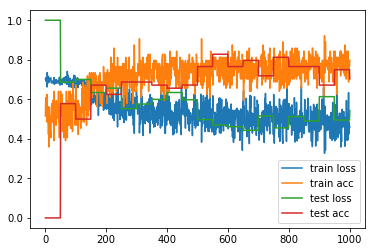

In [23]:
# YOUR TRAINING HERE
num_steps = 1001
train_loss_hist=[]
train_acc_hist=[]
test_loss_hist=[]
test_acc_hist=[]
test_loss=1.0
test_acc=0.0
test_step_no=0
test_step_no_print=0
train_step_use=0
mean_train_loss=0
total_train_loss=0
mean_test_accuracy=0
total_test_accuracy=0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    test_step_no=0
    test_step_no_print=0
    train_step_use=0
    for step in range(num_steps):
        # TODO: get data for a batch
        if(step>935):
            train_step_use=step-935
        else:
            train_step_use=step
        batch_tweets = train_tweets[train_step_use * batch_size: (1 + train_step_use) * batch_size]
        batch_labels = train_labels[train_step_use * batch_size: (1 + train_step_use) * batch_size]
        #training_batch_x = X_train[itr * batch_size: (1 + itr) * batch_size]
        #training_batch_y = y_train[itr * batch_size: (1 + itr) * batch_size]
        
        # TODO: run the 'optimizer', 'loss', and 'acc' operations in the graph using the batch data
        sess.run(optimizer, feed_dict={tweets: batch_tweets, labels: batch_labels})
        train_loss=sess.run(loss, feed_dict={tweets: batch_tweets, labels: batch_labels})
        train_acc=sess.run(acc, feed_dict={tweets: batch_tweets, labels: batch_labels})
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc)
        total_train_loss=total_train_loss+train_loss
        mean_train_loss=total_train_loss/(step+1)
        #print('step {}: train_loss = {} and train_acc = {}'.format(step+1, train_loss,train_acc))
        #_, train_loss, train_acc = pass
                
        if ((step % 50 == 0) and (step>10)):
            # TODO: get test accuracy and loss, and print them out.
            #test_step=int(step/50)
            test_batch_tweets = test_tweets[test_step_no * batch_size: (1 + test_step_no) * batch_size]
            test_batch_labels = test_labels[test_step_no * batch_size: (1 + test_step_no) * batch_size] 
            #test_batch_tweets=test_tweets
            #test_batch_labels=test_labels
            test_loss=sess.run(loss, feed_dict={tweets: test_batch_tweets, labels: test_batch_labels})
            test_acc=sess.run(acc, feed_dict={tweets: test_batch_tweets, labels: test_batch_labels})
            test_loss_hist.append(test_loss)
            test_acc_hist.append(test_acc)
            total_test_accuracy=total_test_accuracy+test_acc
            print('train step {}, i.e. test step {}: test_loss = {}, test_acc = {} and mean training loss = {}'.format(step,test_step_no_print+1, test_loss,test_acc,mean_train_loss))
            test_step_no=test_step_no+1
            test_step_no_print=test_step_no_print+1
            if(test_step_no==15):
                test_step_no=1
        else:
            test_loss_hist.append(test_loss)
            test_acc_hist.append(test_acc)
    vocabulary_embeddings = sess.run(embedding_matrix)
    mean_test_accuracy=total_test_accuracy/20
    print('Final Step no {}: Final mean train_loss = {}, Final mean test accuracy = {} and Final step train_loss = {}'.format(step+1, mean_train_loss,mean_test_accuracy,train_loss))
    plt.plot(train_loss_hist, label="train loss")
    plt.plot(train_acc_hist, label="train acc")
    plt.plot(test_loss_hist, label="test loss")
    plt.plot(test_acc_hist, label="test acc")
    plt.legend()
    plt.show()
    
    


### Visualize word vectors via tSNE

<span style="color:red">__TODO:__</span>

First, you need to retrieve **embedding matrix** from the network. Then use tSNE to reduce each low-dimensional word vector into a 2D vector. 

And then, you should visualize some interesting word pairs in 2D panel. You may find **scatter** function in **matplotlib.pyplot** useful.


Hint: You can use **TSNE** tool provided in **scikit-learn**. And if you encounter dead kernel problem caused by "Intel MKL FATAL ERROR: Cannot load libmkl_avx.so or libmkl_def.so", please reinstall scikit-learn without MKL, ie., **conda install nomkl numpy scipy scikit-learn numexpr**. 

Here we provide some word pairs for you, like female-male or country-capital. And you can observe that these word-pair will look parallel with each other in a 2D tSNE panel. And you can find some other words and explore their relationship.

The result for female-male pairs should look like, and you will observe that king-men and queen-women are parallel to each other in a 2D panel.


![](./img/tsne_female_male.png)

In [24]:
female_male = ["men", "women", "king", "queen"]
country_capital = ["spain", "madrid", "italy", "rome", "japan", "tokyo"]
# you can try some other words

In [ ]:
from sklearn.manifold import TSNE
### your code here
visualized_word_vectors = TSNE(n_components=2,init='pca', n_iter=1000, random_state=10).fit_transform(vocabulary_embeddings)


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def word_vector_function(vocab,words):
    count = [np.where(vocab==word) for word in words]
    output = []
    for item in range(len(count)):
        output.append(count[item][0][0])
    return output
plot1 = visualized_word_vectors[word_vector_function(vocabulary,female_male)]

plt.scatter(plot1[:,0],plot1[:,1])

for i, txt in enumerate(female_male):
    plt.annotate(txt, (plot1[i,0],plot1[i,1]))
plt.show()

NameError: name 'visualized_word_vectors' is not defined

In [ ]:
plot2 = visualized_word_vectors[word_vector_function(vocabulary,country_capital)]

plt.scatter(plot2[:,0],plot2[:,1])

for i, txt in enumerate(country_capital):
    plt.annotate(txt, (plot2[i,0],plot2[i,1]))
plt.show()

#### <span style="color:red">TODO: </span> describe your observation of these word vectors

Answer: **[fill in here]**